In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import theano
import theano.tensor as T

In [2]:
c = T.scalar('c')
v = T.vector('v')
A = T.matrix('A')

In [3]:
u = A.dot(v)
matrix_times_vector = theano.function(inputs=[A,v], outputs=[u])

A_val = np.array([[1,2], [3,4]])
v_val = np.array([5,6])
u_val = matrix_times_vector(A_val, v_val)
print(u_val)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


[array([ 17.,  39.])]


In [4]:
x = theano.shared(20.0, 'x')

cost = x*x + x
x_update = x - 0.3 * T.grad(cost, x)

train = theano.function(inputs=[], outputs=cost, updates=[(x, x_update)])

for i in range(25):
    cost_val = train()
    print(cost_val)
    
print(x.get_value)

420.0
66.99000000000001
10.508400000000005
1.471344000000001
0.025415040000000264
-0.20593359359999994
-0.24294937497599997
-0.24887189999616
-0.2498195039993856
-0.2499711206399017
-0.24999537930238427
-0.2499992606883815
-0.24999988171014104
-0.24999998107362256
-0.2499999969717796
-0.24999999951548474
-0.24999999992247757
-0.24999999998759642
-0.24999999999801542
-0.24999999999968248
-0.2499999999999492
-0.24999999999999187
-0.2499999999999987
-0.2499999999999998
-0.24999999999999997
<bound method SharedVariable.get_value of x>


In [18]:
def y2indicator(y, K):
    '''Transfor Y into an indicator matrix
    The indicator matrix will be an NxK matrix.
    
    N : number of samples
    K : number of classes in the output
    '''
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        j = int(y[i])
        ind[i, j] = 1
    return ind

def get_normalized_data():
    df = pd.read_csv('data/train.csv')
    data = df.as_matrix().astype(np.float32)
    
    np.random.shuffle(data)
    Y = data[:, 0]
    X = data[:, 1:]
    mu = X.mean(axis=0)
    std  = X.std(axis=0)
    # if value equals to 0 replace by 1
    np.place(std, std==0, 1) 
    X = (X - mu)/ std
    
    return X, Y    

def error_rate(p, t):
    return np.mean(p != t)

In [30]:
X, Y = get_normalized_data()
max_iter = 10
print_period = 50

lr = 4e-5
reg = 1e-2

# D : dimensionality (features), K: classes
N, D = X.shape
M = 300
K = len(np.unique(Y))
batch_sz = 500
n_batches = int( N / batch_sz )

Xtrain = X[:-1000,]
Xtest  = X[-1000:,]
Ytrain = Y[:-1000]
Ytest  = Y[-1000:]
Ytrain_ind = y2indicator(Ytrain, K)
Ytest_ind = y2indicator(Ytest, K)

W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

In [31]:
# Inputs
thX = T.matrix('X')
thT = T.matrix('T')

# Weights
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

# Layers
thZ = T.tanh( thX.dot(W1) + b1 )
thY = T.nnet.softmax( thZ.dot(W2) + b2 )

# cost
cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())
prediction = T.argmax(thY, axis=1)

# Update
update_W1 = W1 - lr * T.grad(cost, W1)
update_b1 = b1 - lr * T.grad(cost, b1)
update_W2 = W2 - lr * T.grad(cost, W2)
update_b2 = b2 - lr * T.grad(cost, b2)

# train
train = theano.function(inputs=[thX, thT],
                       updates=[(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)])

# prediction function - classification rate
get_prediction = theano.function(inputs=[thX, thT],
                                outputs=[cost, prediction])

Cost / err at iteration i=0, j=0: 2450.3838296045283 / 0.905
Cost / err at iteration i=0, j=50: 828.5692195906582 / 0.206
Cost / err at iteration i=1, j=0: 662.4843199230633 / 0.171
Cost / err at iteration i=1, j=50: 547.3745002446677 / 0.141
Cost / err at iteration i=2, j=0: 506.90953436227596 / 0.134
Cost / err at iteration i=2, j=50: 464.02751717934945 / 0.128
Cost / err at iteration i=3, j=0: 445.5696420620887 / 0.123
Cost / err at iteration i=3, j=50: 422.1080702242691 / 0.116
Cost / err at iteration i=4, j=0: 411.3856385857151 / 0.111
Cost / err at iteration i=4, j=50: 396.0662685656668 / 0.109
Cost / err at iteration i=5, j=0: 388.9588967356917 / 0.107
Cost / err at iteration i=5, j=50: 377.8720612969308 / 0.107
Cost / err at iteration i=6, j=0: 372.7461179061334 / 0.106
Cost / err at iteration i=6, j=50: 364.1678412139501 / 0.105
Cost / err at iteration i=7, j=0: 360.24827542650553 / 0.105
Cost / err at iteration i=7, j=50: 353.29734125631063 / 0.105
Cost / err at iteration i=8

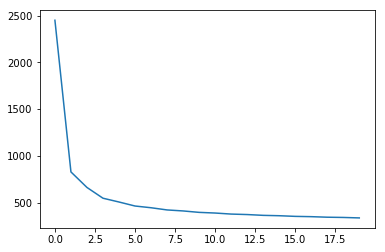

In [32]:
LL = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz: (j*batch_sz + batch_sz), ]
        Ybatch = Ytrain_ind[j*batch_sz: (j*batch_sz + batch_sz), ]
        
        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print('Cost / err at iteration i={}, j={}: {} / {}'.format(i, j, cost_val, err))
            LL.append(cost_val)
            
plt.plot(LL)
plt.show()